## Introduction

This notebook performs end-to-end data cleaning, preprocessing, and exploratory
analysis on the DoorDash historical delivery dataset.  
The goal is to convert the raw event-level records into a structured,
model-ready dataset that accurately reflects operational conditions without
introducing label leakage.

We begin by loading the raw data and validating column types.  

We then apply the full preprocessing pipeline, which handles timestamp
normalization, hierarchical imputation, outlier filtering, and feature
construction. 

Finally, we explore key temporal, order-level, store-level, and
marketplace features to build intuition for how they relate to delivery time.


In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = next(
    (p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / "src").exists()),
    Path.cwd()
)

sys.path.insert(0, str(project_root))



In [2]:
# Module imports 
from src.preprocessing_imputation import preprocess_impute

## 1. Load and Inspect Raw Data

We load the raw CSV file and enforce consistent data types across integer,
float, categorical, and datetime fields.  

This step provides an initial view of:
- how many rows are available,
- which columns contain missing values,
- the overall structure of the raw dataset.

Establishing clean and consistent data types up front ensures that downstream
preprocessing steps behave predictably.


In [3]:
# Load raw data
data_path = Path(project_root / "data" / "raw" / "historical_data.csv")

df = pd.read_csv(
    data_path,  
    dtype={
        "order_protocol": "object",
        "market_id": "object",
        "store_id": "object",
        "store_primary_category": "object"
    },
    parse_dates=["created_at","actual_delivery_time"])

# Convert integer columns to int32
int_cols = [
    "total_items", "subtotal", "num_distinct_items",
    "min_item_price", "max_item_price"
    
]
df[int_cols] = df[int_cols].astype("int32")

# Telemetry + estimated driving duration to float32
float_cols = [
    "total_onshift_dashers", "total_busy_dashers",
    "total_outstanding_orders", "estimated_store_to_consumer_driving_duration",
    "estimated_order_place_duration"
]
df[float_cols] = df[float_cols].astype("float32")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  object        
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  object        
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  object        
 6   total_items                                   197428 non-null  int32         
 7   subtotal                                      197428 non-null  int32         
 8   num_distinct_items                            197428 n

## 2. Preprocessing and Imputation Pipeline

We apply the centralized preprocessing pipeline, which bundles all leakage-safe
transformations into a single ordered sequence. Major components include:

**Timestamp processing**
- convert timestamps to a common timezone,
- construct hour, weekday, month, and cyclical encodings.

**Missing data handling**
- hierarchical median imputation for numeric fields (store → market → global),
- categorical imputation using store-level modes,
- telemetry completeness flagging.

**Target engineering**
- compute delivery duration in seconds,
- remove unrealistic or extreme outliers using an IQR-based method.

**Feature engineering**
- order-level metrics (value, size, variety),
- store-level metrics (average durations, order volume),
- marketplace load and congestion metrics,
- lag-based and momentum features that capture short-term dynamics.

Running these steps produces a clean, enriched dataset that aligns with
realistic model-inference conditions.

Details for the preprocessing functions can be found in the `preprocessing_imputation.py` file inside of the `src` directory.


In [4]:
# Preprocess and impute missing values
# Orchestration function handling all preprocessing + imputation steps
df = preprocess_impute(df, verbose=True)

Starting preprocessing and imputation pipeline...


Preprocessing Pipeline:   0%|          | 0/18 [00:00<?, ?step/s]

Preprocessing Pipeline:  17%|█▋        | 3/18 [00:00<00:00, 23.13step/s]

Running: convert_timezone_created_at
Running: convert_timezone_actual_delivery_time
Running: construct_temporal_features
Running: impute_actual_delivery_time
Running: impute_market_id
Running: impute_store_primary_category


Preprocessing Pipeline:  44%|████▍     | 8/18 [00:01<00:01,  6.93step/s]

Running: impute_order_protocol
Running: impute_estimated_duration
Running: impute_marketplace_telemetry


Preprocessing Pipeline:  78%|███████▊  | 14/18 [00:01<00:00,  9.01step/s]

Running: compute_delivery_time
Running: filter_target_delivery_outliers
IQR filtering:
  Q1=2,104.00, Q3=3,381.00, IQR=1,277.00
  lower bound=0.00, upper bound=7,212.00
  Rows before: 197,421
  Rows after: 196,337  (removed 1,084)
Running: compute_item_metrics
Running: filter_item_count_outliers
IQR filtering:
  Q1=2.00, Q3=4.00, IQR=2.00
  lower bound=0.00, upper bound=34.00
  Rows before: 196,337
  Rows after: 196,285  (removed 52)
Running: compute_store_features
Running: compute_marketplace_load
Running: compute_lagged_telemetry


Preprocessing Pipeline: 100%|██████████| 18/18 [00:03<00:00,  5.51step/s]

Running: compute_velocity_features
Running: compute_robust_buckets
Preprocessing and imputation pipeline complete.


In [5]:
pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_unique": df.nunique(),
}).head(60)

,dtype,n_unique
market_id,object,7
created_at,"datetime64[ns, US/Pacific]",180056
actual_delivery_time,"datetime64[ns, US/Pacific]",177145
store_id,object,6734
store_primary_category,object,75
order_protocol,object,8
order_total_items,int32,34
order_subtotal,int32,8350
order_num_distinct_items,int32,20
order_min_item_price,int32,2297


## 3. Delivery Time Distribution

We examine the distribution of the cleaned delivery-time target.  
This confirms that outlier removal worked as intended and gives a clearer view
of the typical delivery durations in the dataset.

Most deliveries fall between ~2,000 and ~3,500 seconds, with a long tail toward
longer deliveries, a pattern consistent with real-world operational delays.


In [6]:
print("Target delivery seconds statistics after preprocessing and outlier removal:")
print(df["target_delivery_seconds"].describe())

Target delivery seconds statistics after preprocessing and outlier removal:
count    196285.000000
mean       2825.896105
std        1016.034334
min         101.000000
25%        2101.000000
50%        2653.000000
75%        3365.000000
max        7212.000000
Name: target_delivery_seconds, dtype: float64


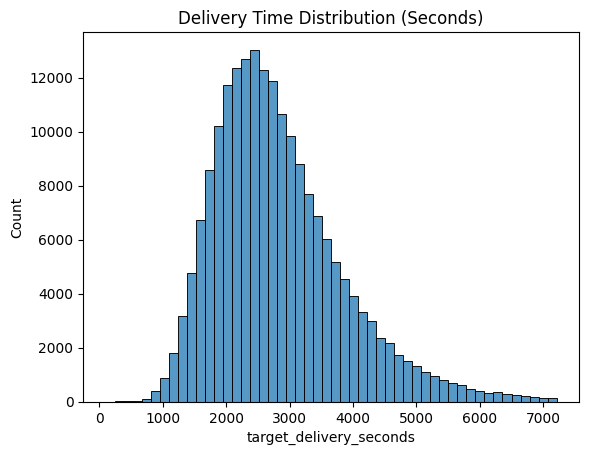

In [7]:
sns.histplot(df["target_delivery_seconds"], bins=50)
plt.title("Delivery Time Distribution (Seconds)")
plt.show()


In [8]:
print("=== Missing Values After Preprocessing ===")
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]
print("=== Telemetry Missing Flag ===")
print(df["load_telemetry_missing"].value_counts(dropna=False))

=== Missing Values After Preprocessing ===
=== Telemetry Missing Flag ===
load_telemetry_missing
0    180111
1     16174
Name: count, dtype: int64


## 4. Time-Based Feature Behavior

To understand temporal patterns, we plot delivery time against features such as:

- hour of day,
- day of week,
- weekend vs weekday,
- rush-hour indicator.

These relationships reveal broad operational behaviors, such as longer delivery
times during peak dining hours or higher demand periods.  
The cyclical sine/cosine encodings show the smooth, circular structure of the
underlying time features.


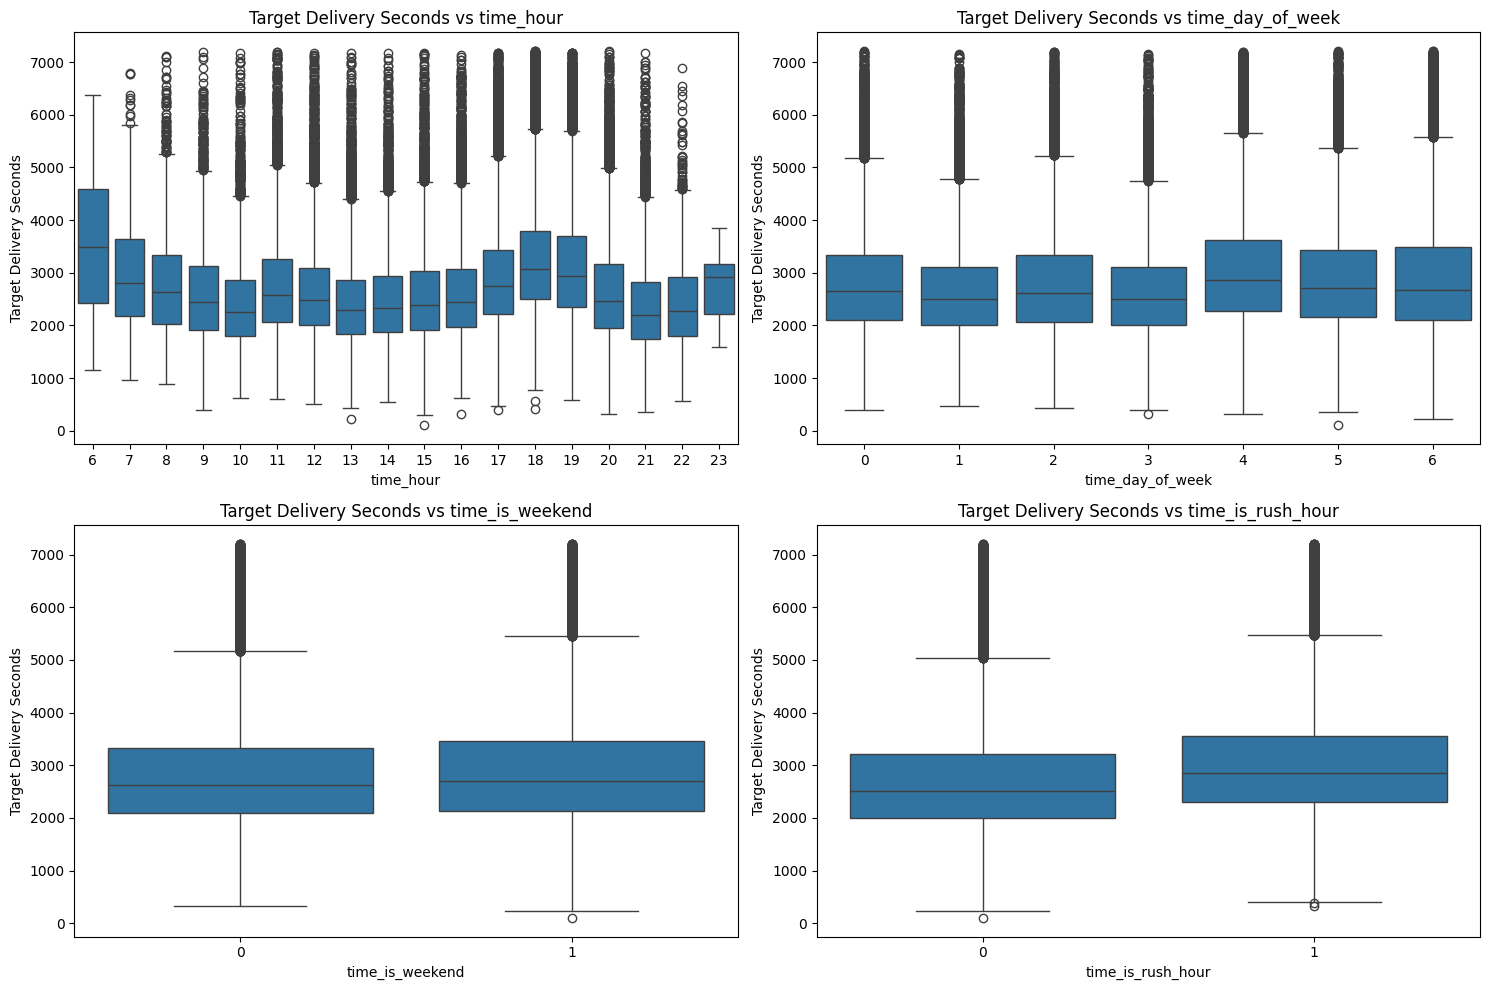

In [9]:
time_features = [
    "time_hour",
    "time_day_of_week",
    "time_is_weekend",
    "time_is_rush_hour"
]

# Plot on 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Ensure axes is a 2D ndarray so .flatten() is available to the type-checker
if isinstance(axes, np.ndarray):
    arr_axes = axes
else:
    arr_axes = np.array([[axes]])

for ax, feature in zip(arr_axes.flatten(), time_features):
    sns.boxplot(x=feature, y="target_delivery_seconds", data=df, ax=ax)
    ax.set_title(f"Target Delivery Seconds vs {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Target Delivery Seconds")

plt.tight_layout()
plt.show()


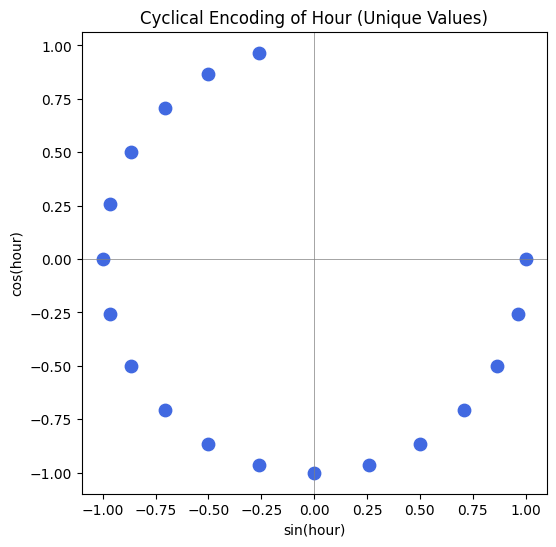

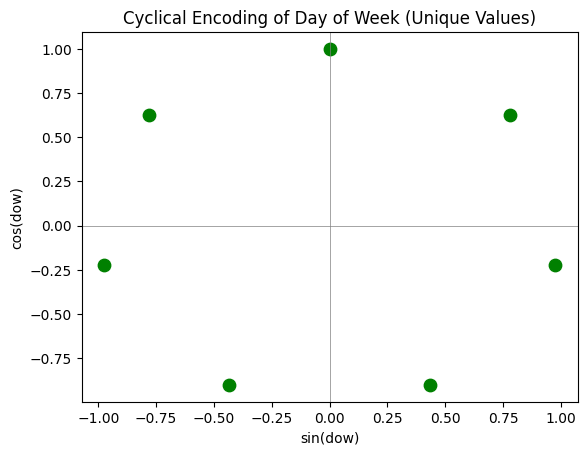

In [10]:
plt.figure(figsize=(6,6))

unique_hours = df[["time_hour_sin", "time_hour_cos"]].drop_duplicates()

plt.scatter(unique_hours["time_hour_sin"],
            unique_hours["time_hour_cos"],
            s=80,
            color="royalblue")

plt.title("Cyclical Encoding of Hour (Unique Values)")
plt.xlabel("sin(hour)")
plt.ylabel("cos(hour)")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.show()

unique_dows = df[["time_dow_sin", "time_dow_cos"]].drop_duplicates()

plt.scatter(unique_dows["time_dow_sin"],
            unique_dows["time_dow_cos"],
            s=80,
            color="green")

plt.title("Cyclical Encoding of Day of Week (Unique Values)")
plt.xlabel("sin(dow)")
plt.ylabel("cos(dow)")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.show()

## 5. Order-Level Feature Exploration

We study how order characteristics relate to delivery time, focusing on:

- subtotal,
- total items,
- number of distinct items,
- high- vs low-value orders.

These features capture how order composition affects prep time complexity,
packing effort, and store throughput. Scatter and box plots help visualize the
strength of these relationships across the dataset.


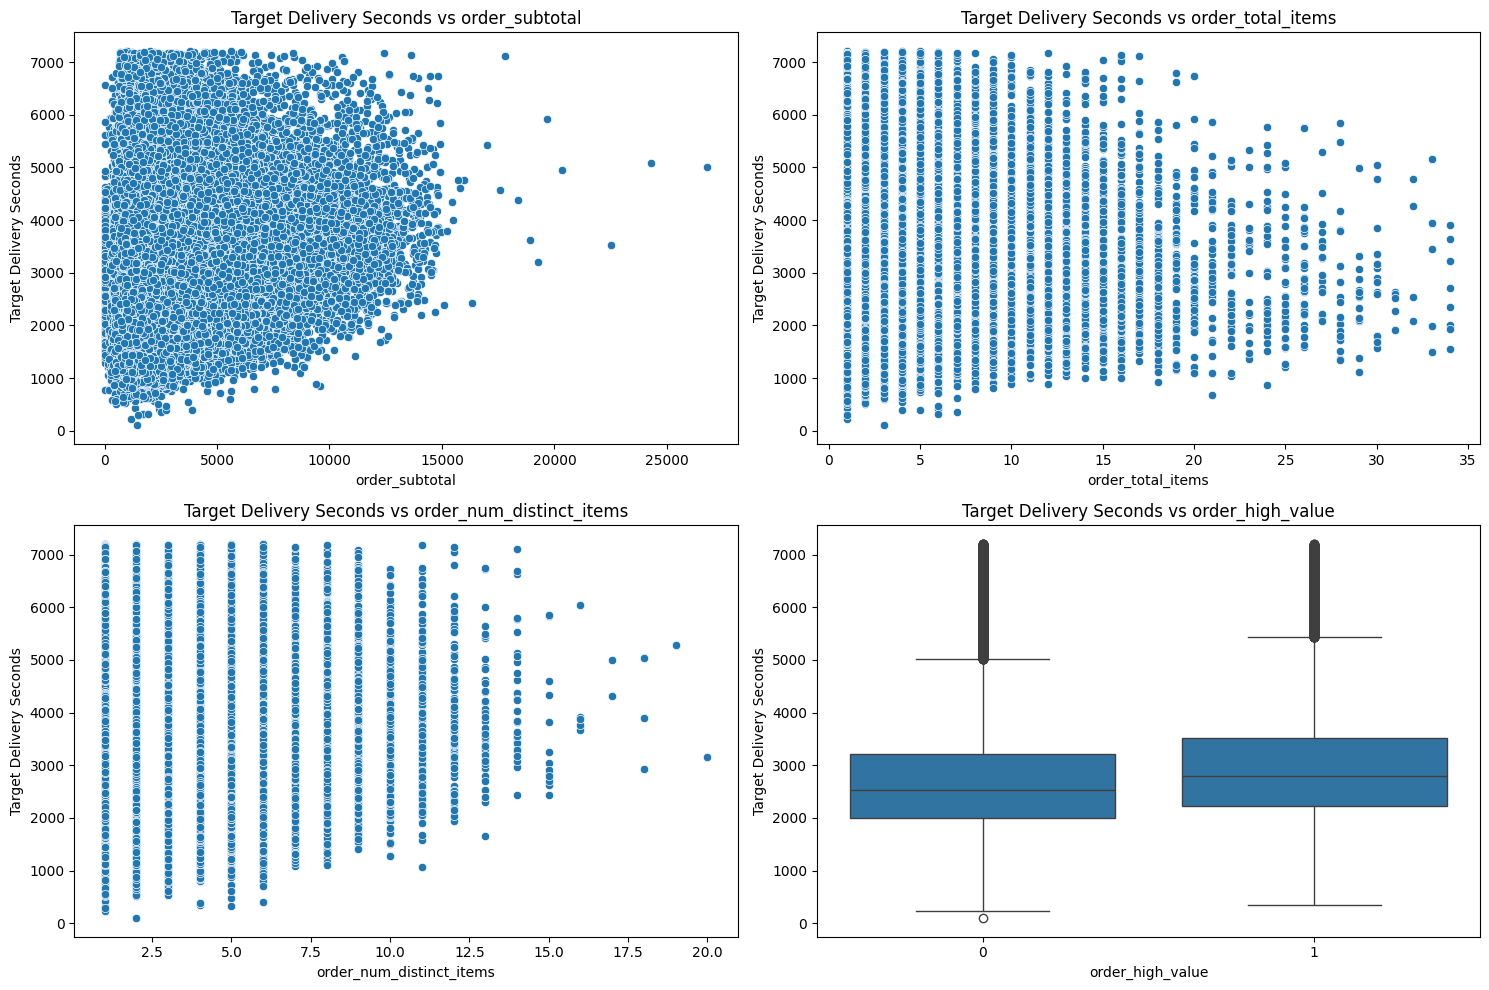

In [11]:
order_features = [
    "order_subtotal",
    "order_total_items",
    "order_num_distinct_items",
    "order_high_value"
]

# Plot on 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Ensure axes is a 2D ndarray so .flatten() is available to the type-checker
if isinstance(axes, np.ndarray):
    arr_axes = axes
else:
    arr_axes = np.array([[axes]])

for ax, feature in zip(arr_axes.flatten(), order_features):
    if feature == "order_high_value":
        sns.boxplot(x=feature, y="target_delivery_seconds", data=df, ax=ax)
    else:
        sns.scatterplot(x=feature, y="target_delivery_seconds", data=df, ax=ax)
    ax.set_title(f"Target Delivery Seconds vs {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Target Delivery Seconds")

plt.tight_layout()
plt.show()


In [12]:
print("Subtotal bucket counts:")
print(df["order_subtotal_bucket"].value_counts().sort_index(), "\n")

print("Total items bucket counts:")
print(df["order_total_items_bucket"].value_counts().sort_index(), "\n")

print("Distinct items bucket counts:")
print(df["order_distinct_items_bucket"].value_counts().sort_index())


Subtotal bucket counts:
order_subtotal_bucket
0    49230
1    49233
2    48757
3    49065
Name: count, dtype: int64 

Total items bucket counts:
order_total_items_bucket
0    40441
1    93893
2    38961
3    19685
4     3305
Name: count, dtype: int64 

Distinct items bucket counts:
order_distinct_items_bucket
0    108485
1     41604
2     46196
Name: count, dtype: int64


## 6. Store-Level Trends

Store behavior can vary significantly, so we examine store order volume and its
distribution. High-volume stores may operate more efficiently, but they may also
experience bottlenecks during peak periods.

Summaries of store-level order counts highlight which stores contribute most to
the dataset and expose potential sources of variation in delivery performance.


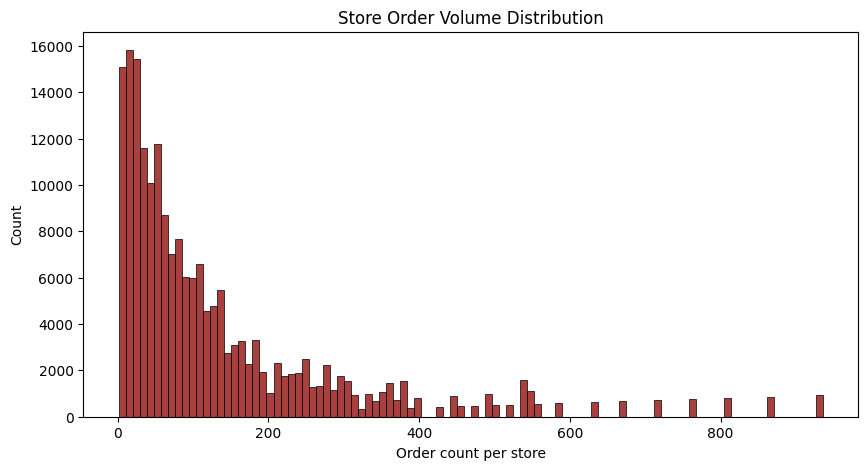

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="store_order_volume", bins=100, color="darkred")
plt.title("Store Order Volume Distribution")
plt.xlabel("Order count per store")
plt.show()


In [14]:
store_volume_stats = df.groupby("store_id")["store_order_volume"].first()

print("Store volume summary:")
print(store_volume_stats.describe())

print("\nTop 10 highest-volume stores:")
print(store_volume_stats.sort_values(ascending=False).head(10))

print("\nBottom 10 lowest-volume stores:")
print(store_volume_stats.sort_values().head(10))


Store volume summary:
count    6734.000000
mean       29.148352
std        56.294209
min         1.000000
25%         4.000000
50%        11.000000
75%        29.000000
max       936.000000
Name: store_order_volume, dtype: float64

Top 10 highest-volume stores:
store_id
6865    936
1311    862
314     813
1686    765
3937    716
6917    667
6074    628
4367    588
3748    559
6503    546
Name: store_order_volume, dtype: int64

Bottom 10 lowest-volume stores:
store_id
5448    1
2822    1
467     1
1647    1
1651    1
2808    1
2806    1
4706    1
6311    1
1666    1
Name: store_order_volume, dtype: int64


## 7. Marketplace Load and Congestion

Delivery time is strongly influenced by real-time supply and demand conditions.
I examine features that describe marketplace load, including:

- busy dasher ratio,
- demand–supply ratio,
- orders per busy dasher,
- rolling averages and rolling standard deviations,
- momentum indicators (rate of change),
- composite indices capturing stress, volatility, and congestion.

These variables reflect whether a market is adequately staffed or strained,
which is a key driver of delivery delays.


In [15]:
load_cols = [
    "load_busy_ratio", "load_demand_supply_ratio", "load_orders_per_busy_dasher",
    "load_roll_outstanding_mean", "load_roll_onshift_mean", "load_roll_busy_mean",
    "load_roll_busy_std", "load_roll_outstanding_std",
    "load_demand_momentum", "load_supply_momentum", "load_busy_momentum",
    "load_supply_stress_index", "load_utilization_volatility", "load_pressure_index"
]

df[load_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
load_busy_ratio,196285.0,0.933496,0.399239,0.000000,0.833333,0.969697,1.000000,31.000000
load_demand_supply_ratio,196285.0,1.190622,0.473247,0.000000,0.937500,1.194444,1.436364,47.000000
load_orders_per_busy_dasher,196285.0,1.275327,0.428057,0.000000,1.045455,1.228571,1.511811,20.000000
load_roll_outstanding_mean,196285.0,56.606197,45.256467,0.400000,22.100000,43.000000,79.100000,264.200000
load_roll_onshift_mean,196285.0,43.981631,29.200474,0.200000,21.200000,36.000000,61.300000,153.400000
load_roll_busy_mean,196285.0,41.061669,26.988383,0.000000,19.300000,35.000000,59.400000,140.600000
load_roll_busy_std,196285.0,13.411208,8.763947,0.000000,6.654155,12.083506,18.979814,58.088056
load_roll_outstanding_std,196285.0,19.239074,14.664802,0.000000,8.096639,15.529184,27.444692,98.732467
load_demand_momentum,196285.0,0.000203,11.347132,-87.666667,-3.333333,0.000000,3.333333,89.666667
load_supply_momentum,196285.0,0.000222,7.899048,-50.666667,-2.666667,0.000000,2.666667,51.666667


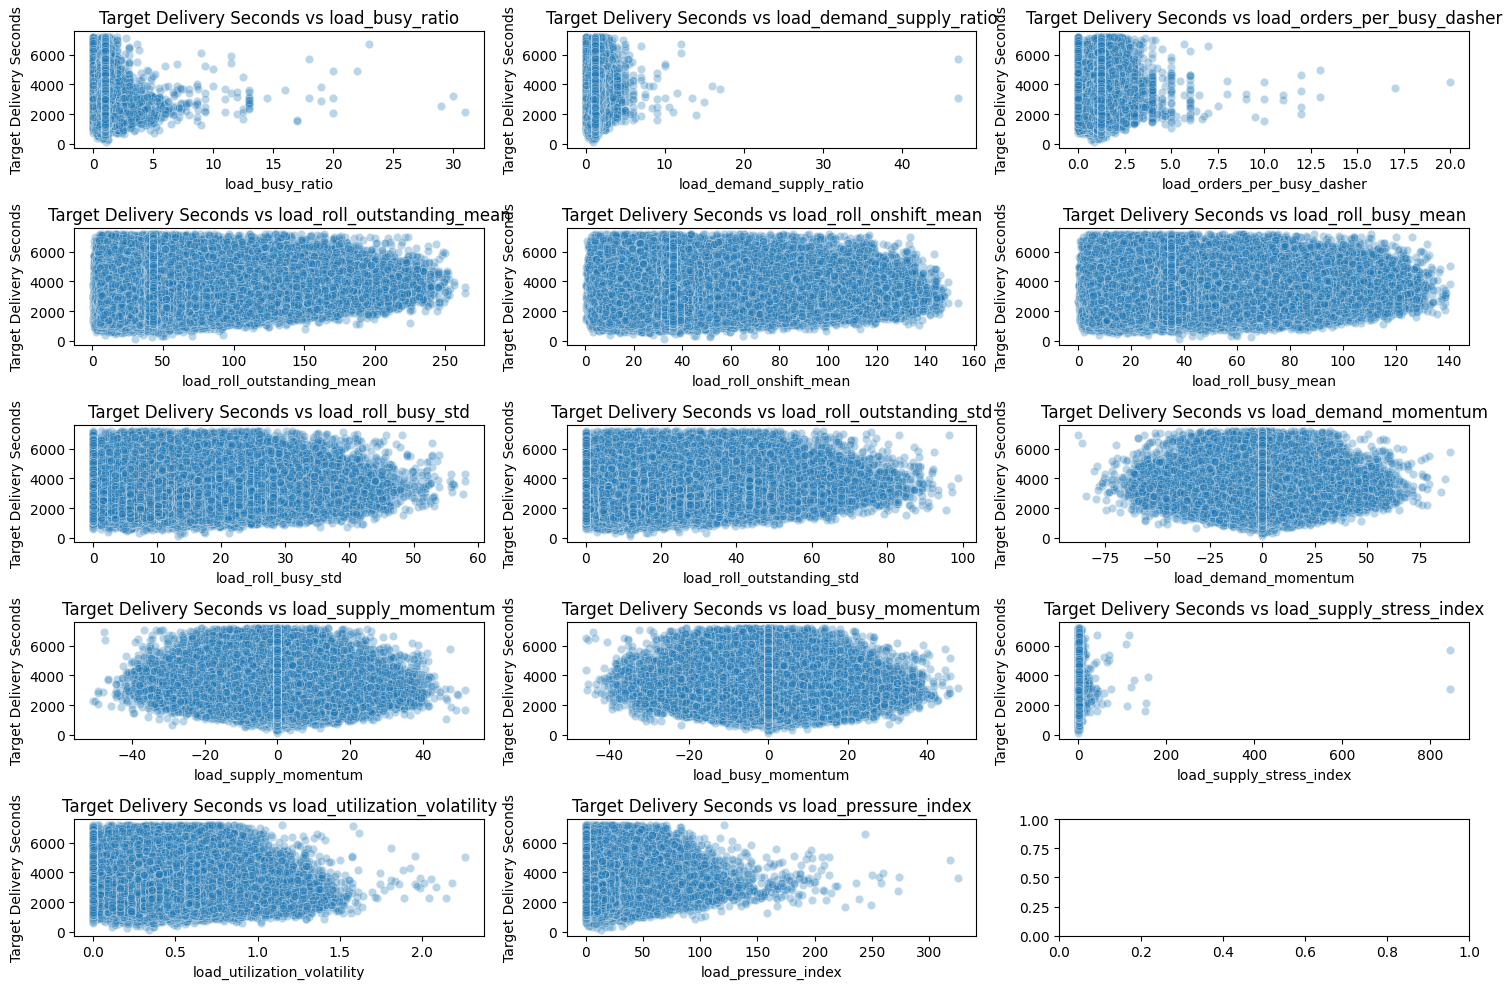

In [16]:

# Plot on 5x3 grid
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
# Ensure axes is a 2D ndarray so .flatten() is available to the type-checker
if isinstance(axes, np.ndarray):
    arr_axes = axes
else:
    arr_axes = np.array([[axes]])

for ax, feature in zip(arr_axes.flatten(), load_cols):
    sns.scatterplot(x=feature, y="target_delivery_seconds", data=df, ax=ax, alpha=0.3)
    ax.set_title(f"Target Delivery Seconds vs {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Target Delivery Seconds")

plt.tight_layout()
plt.show()

## 8. Correlation Structure

A correlation heatmap provides a high-level view of how numeric features relate
to each other and to the target. This helps identify groups of related features,
potential multicollinearity, and early signals that may be useful during model
selection and feature importance analysis.

Sampling is used to improve rendering speed given the size of the dataset.


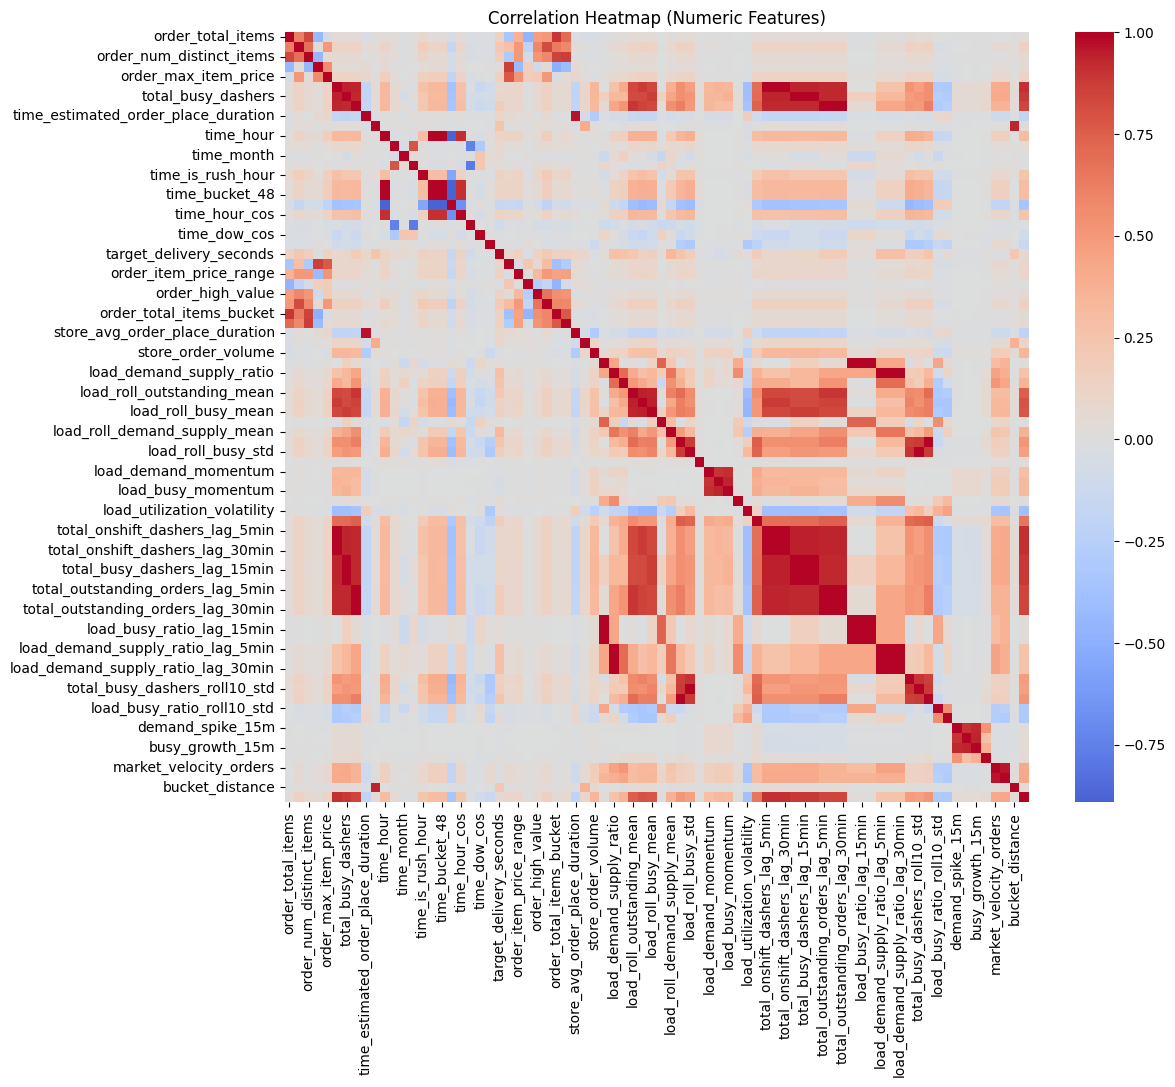

In [17]:
numeric_df = df.select_dtypes(include=['number']).sample(50000)  # sample for speed

corr = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


## 9. Save Processed Dataset

After preprocessing and exploratory analysis, we save the transformed dataset as
a Parquet file in the `processed` directory.  
This allows the modeling notebook to load the data instantly without rerunning
the full preprocessing pipeline.


In [18]:
# Save cleaned data to processed folder
processed_data_path = project_root / "data" / "processed" / "preprocessed_data.parquet"

df.to_parquet(processed_data_path, index=False)

## Conclusion

This notebook created a complete, modeling-ready dataset through robust
preprocessing, hierarchical imputation, outlier filtering, and extensive feature
engineering. The exploratory analysis provided insights into how delivery time
responds to temporal patterns, order characteristics, store behavior, and
marketplace load.

With a cleaned dataset, the next step is to move into advanced feature engineering
and baseline model evaluation to confirm which signals carry the strongest
predictive power.